In [1]:
import sys, os
os.path.dirname(sys.executable)

'/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/bin'

In [5]:
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA')
from ESMCBA.imports import *
from ESMCBA import graph_utils

In [6]:
directory = '/global/scratch/users/sergiomar10/logs/ESMC_Pretrain_logs'
csv_files = glob.glob(os.path.join(directory, '*.csv'))
data = []

for file in csv_files:
    if os.path.getsize(file) > 0:
        try:
            df = pd.read_csv(file)
            base = os.path.basename(file)
            parts = base.split('_')
            hla = parts[-2] if len(parts) >= 2 else 'Unknown'
            max_val_acc = df['Val Acc'].max() if 'Val Acc' in df.columns else None
            data.append({'file': file, 'filename': base, 'HLA': hla, 'max_val_acc': max_val_acc})
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

df_summary = pd.DataFrame(data)
grouped = df_summary.groupby('HLA')

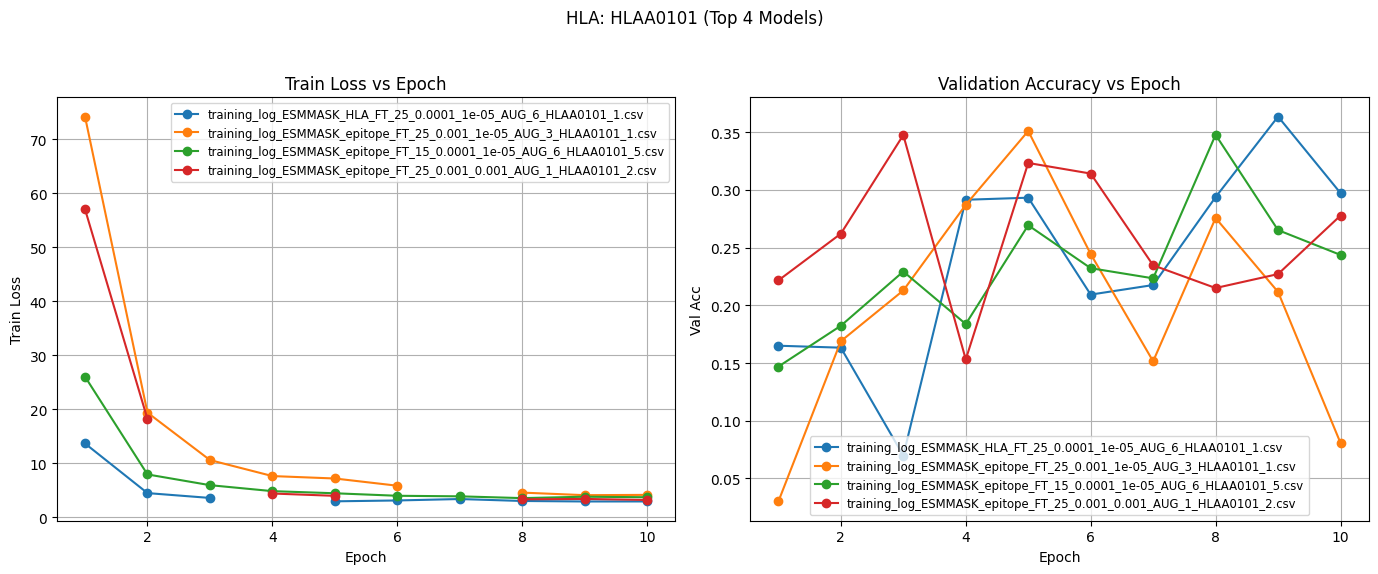

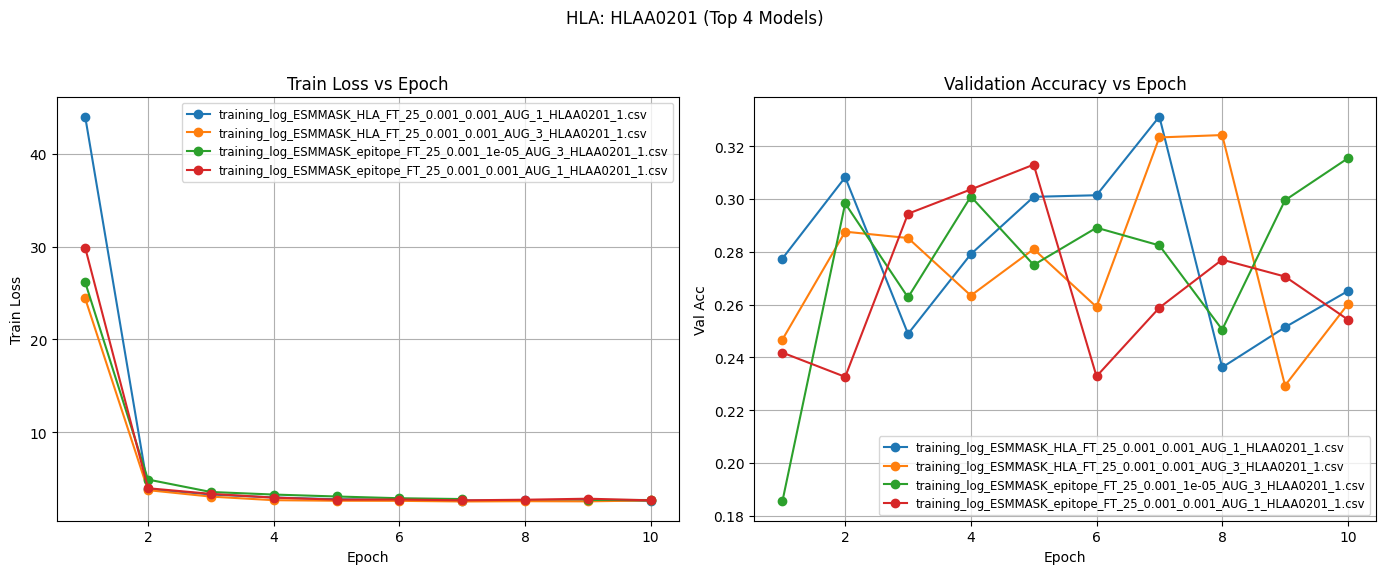

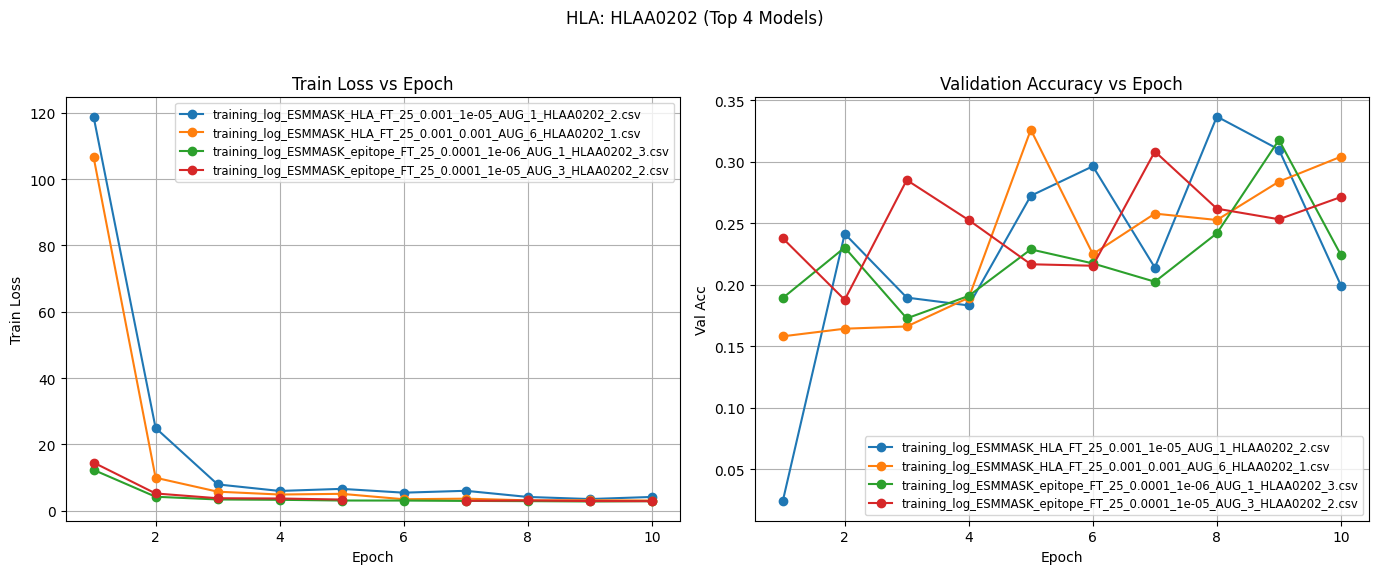

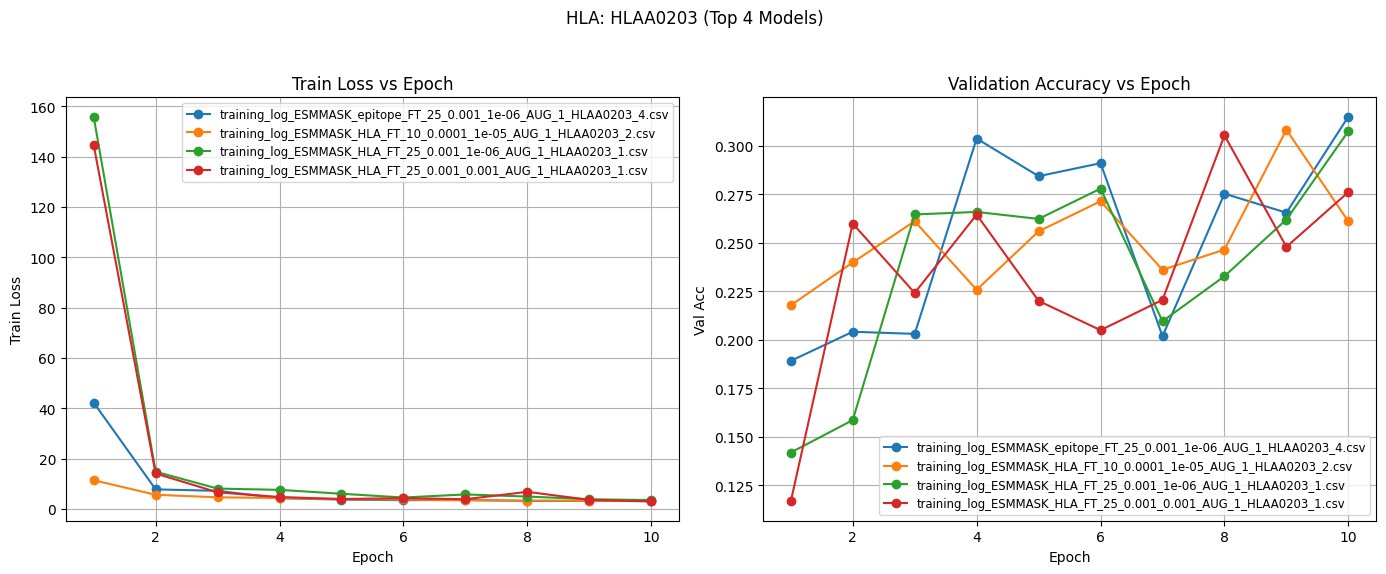

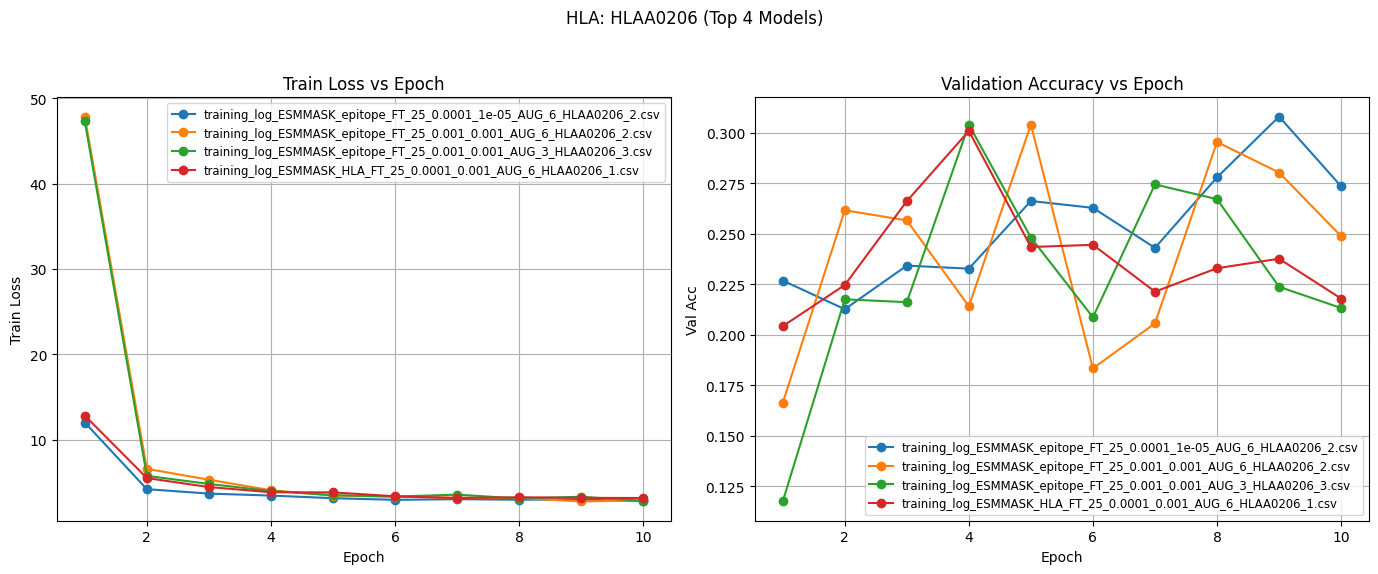

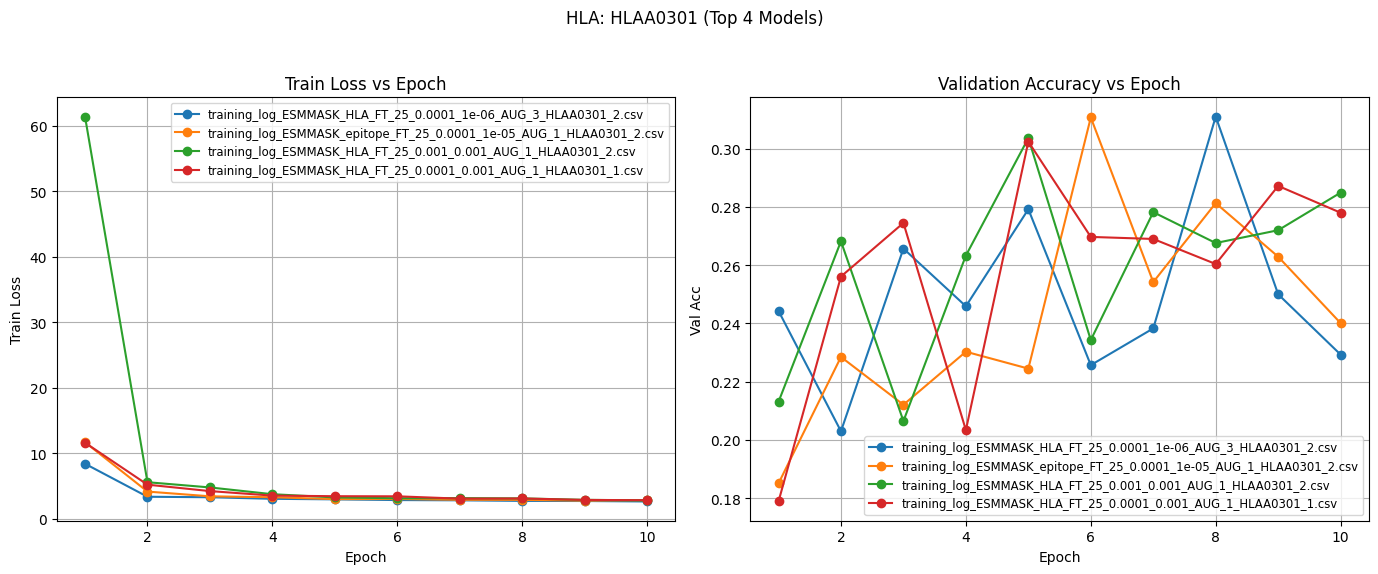

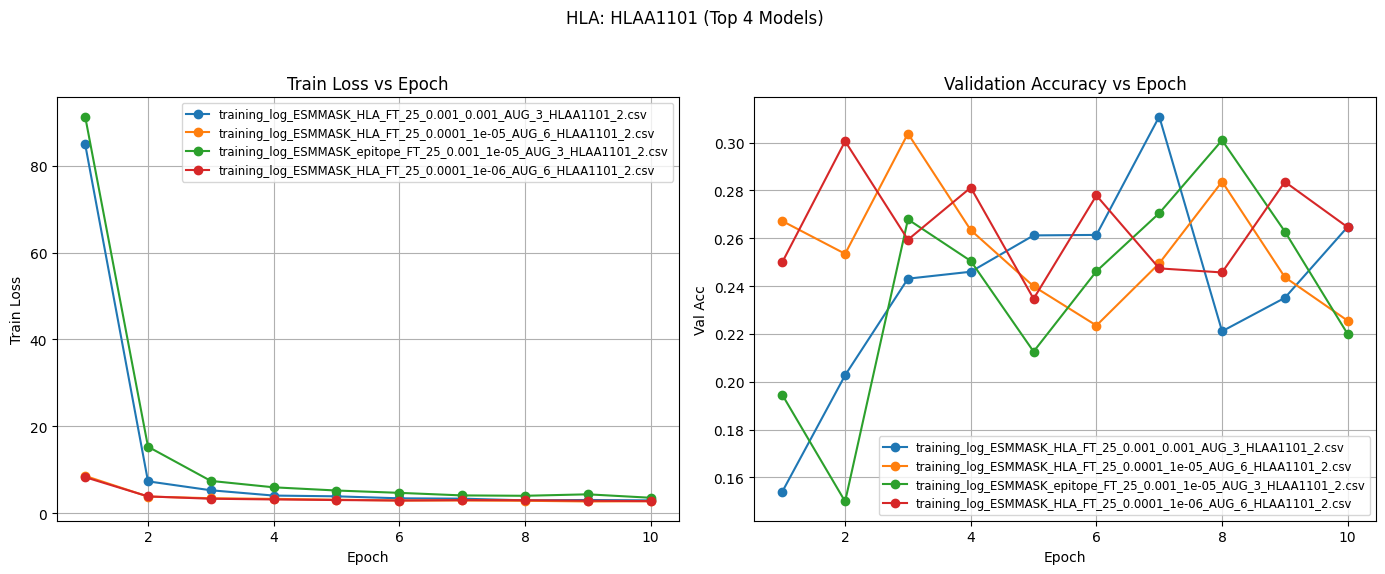

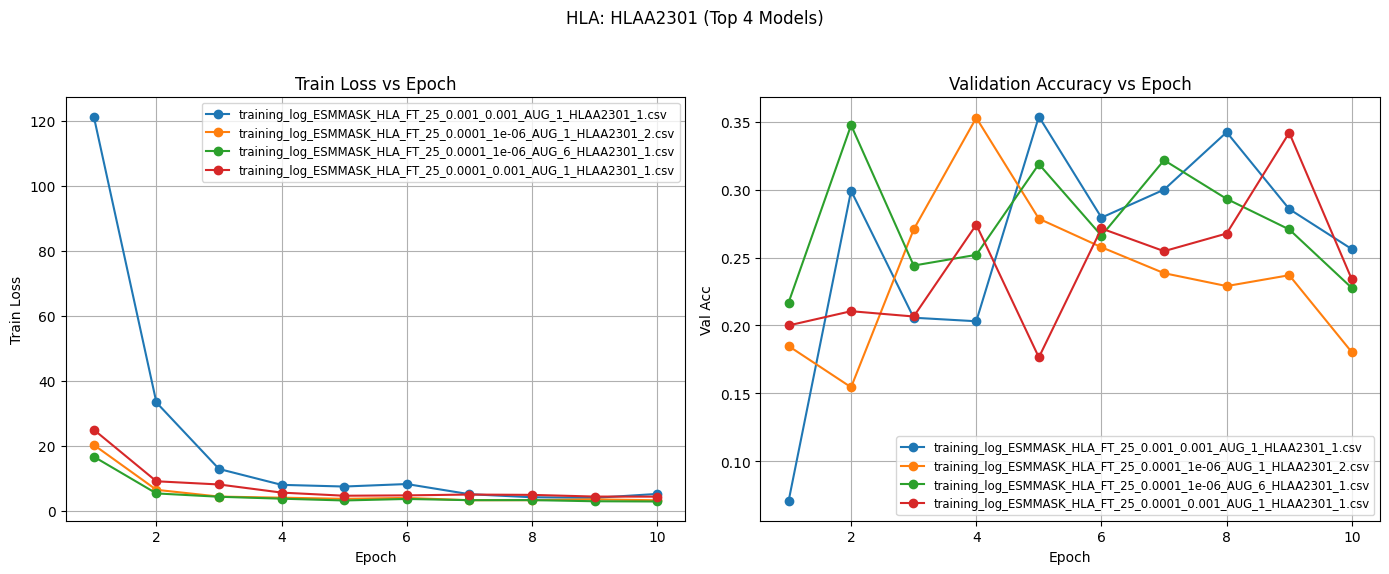

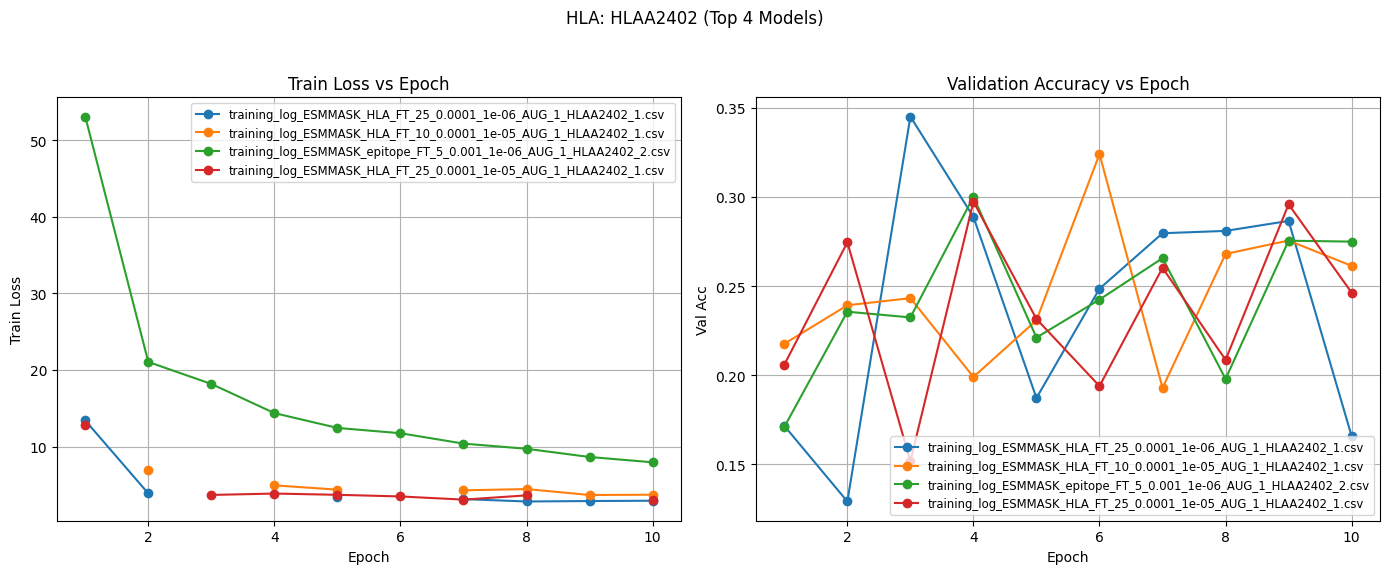

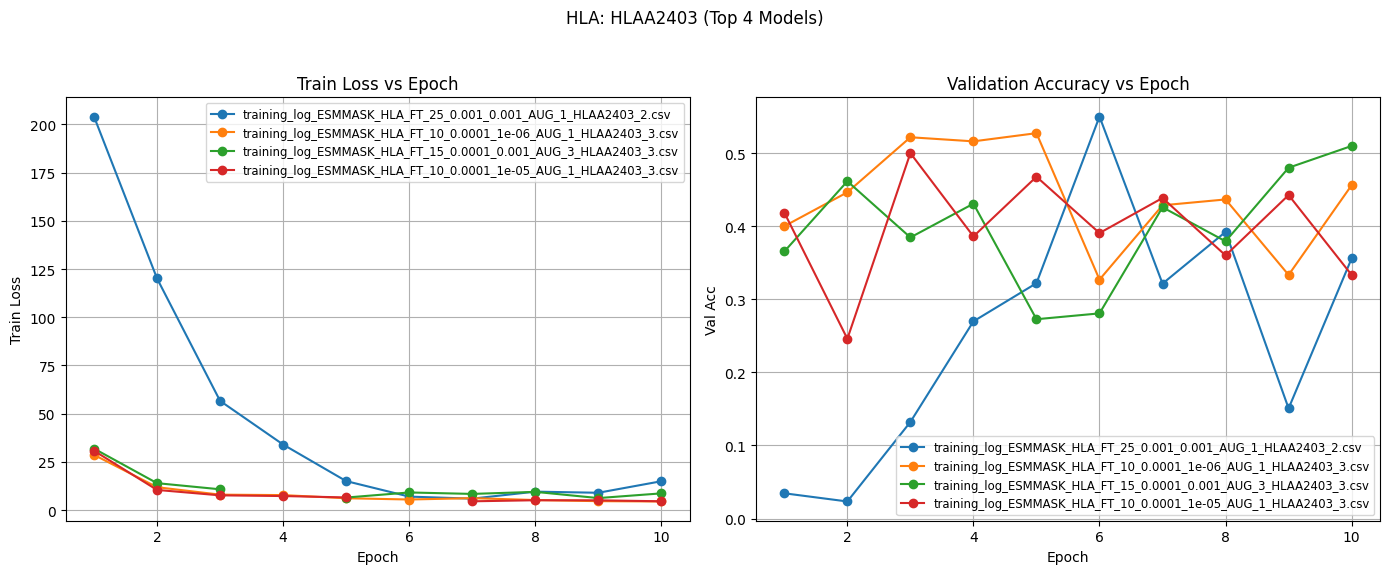

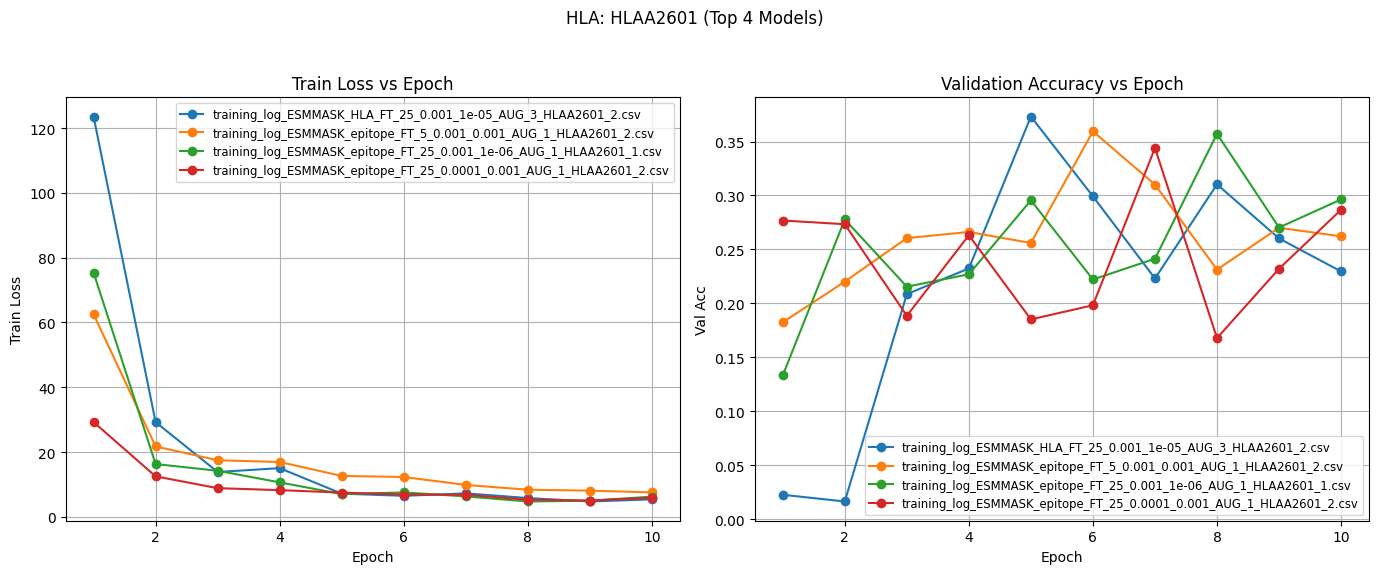

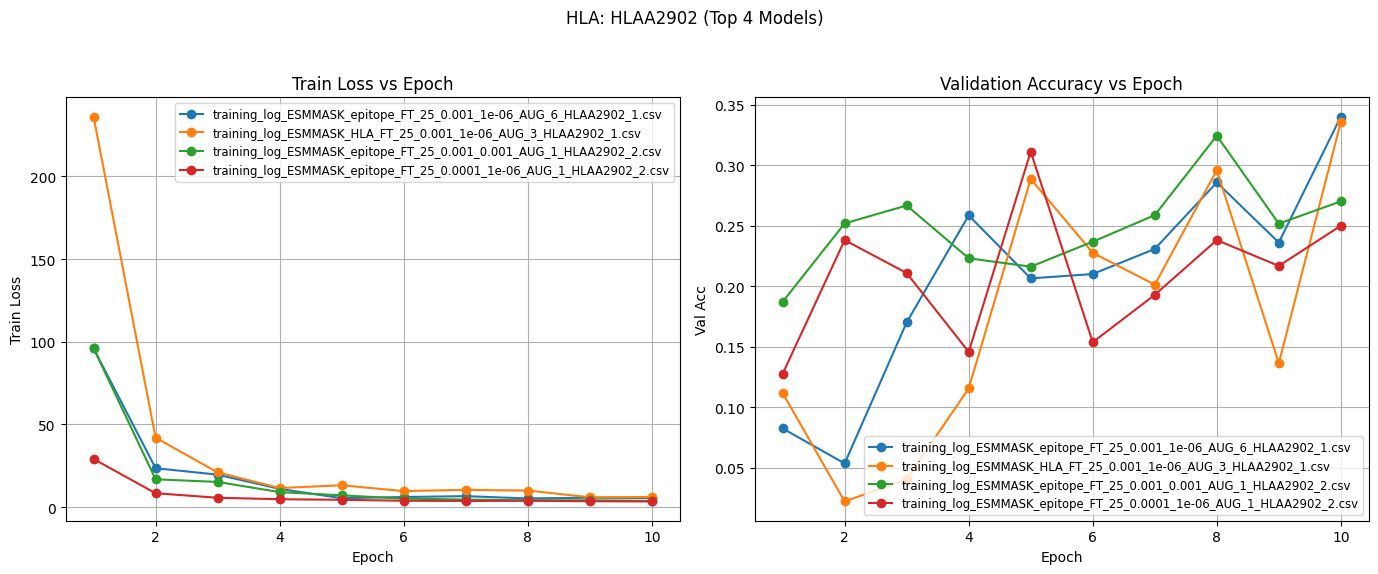

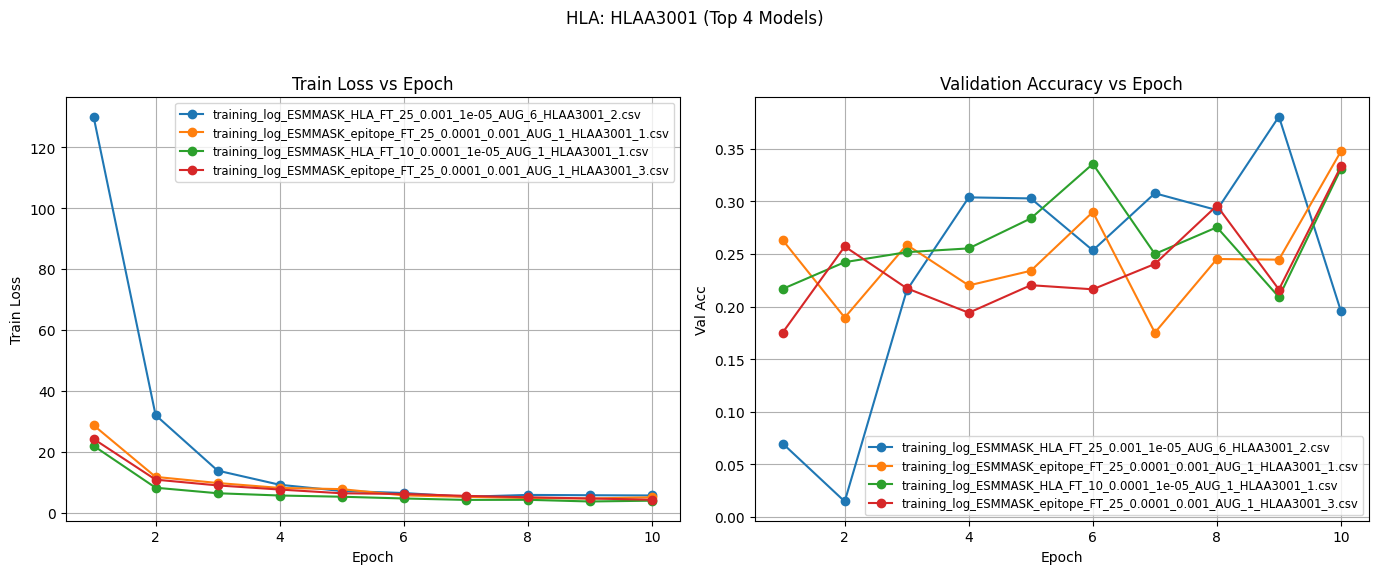

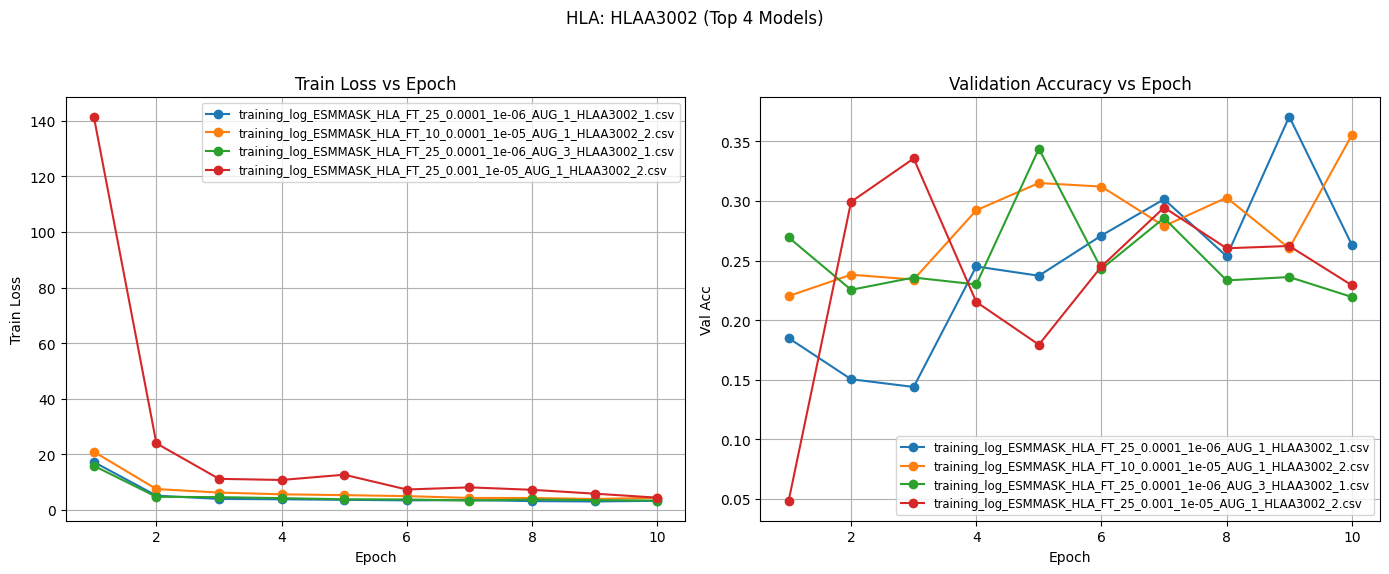

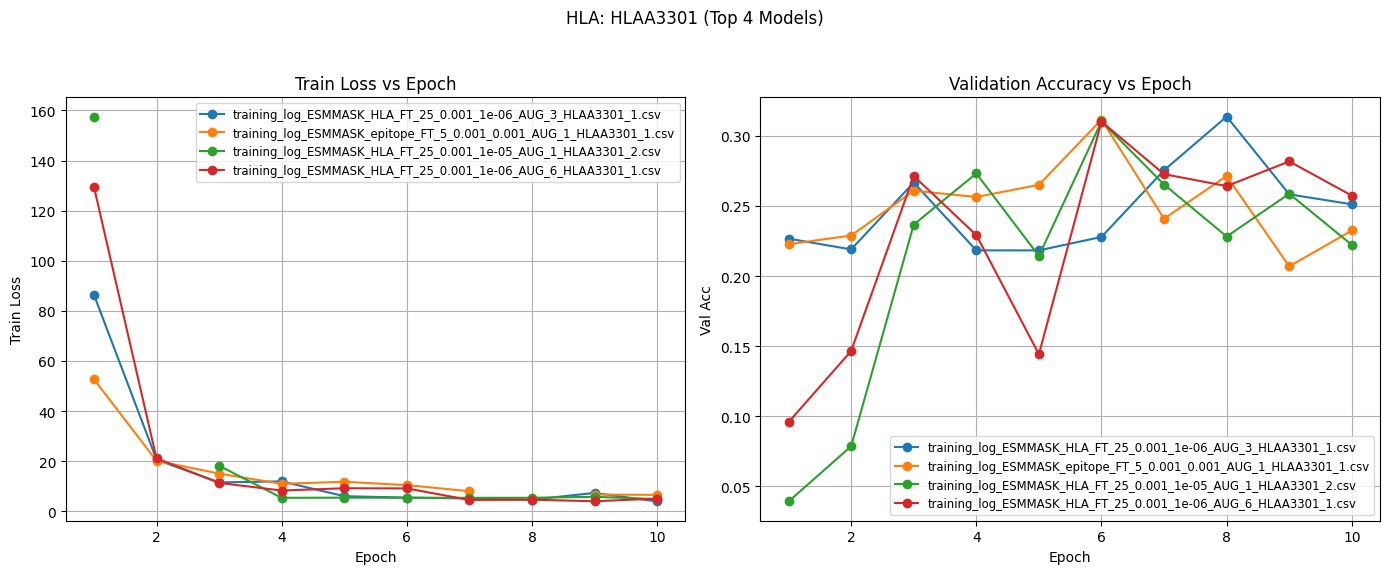

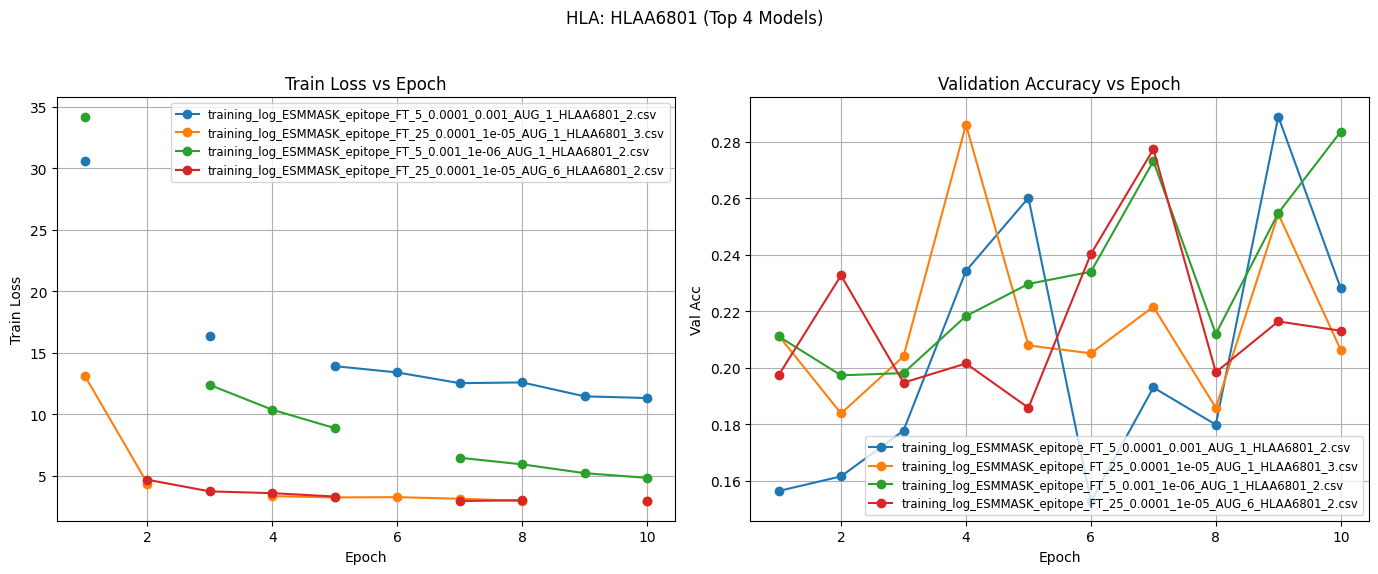

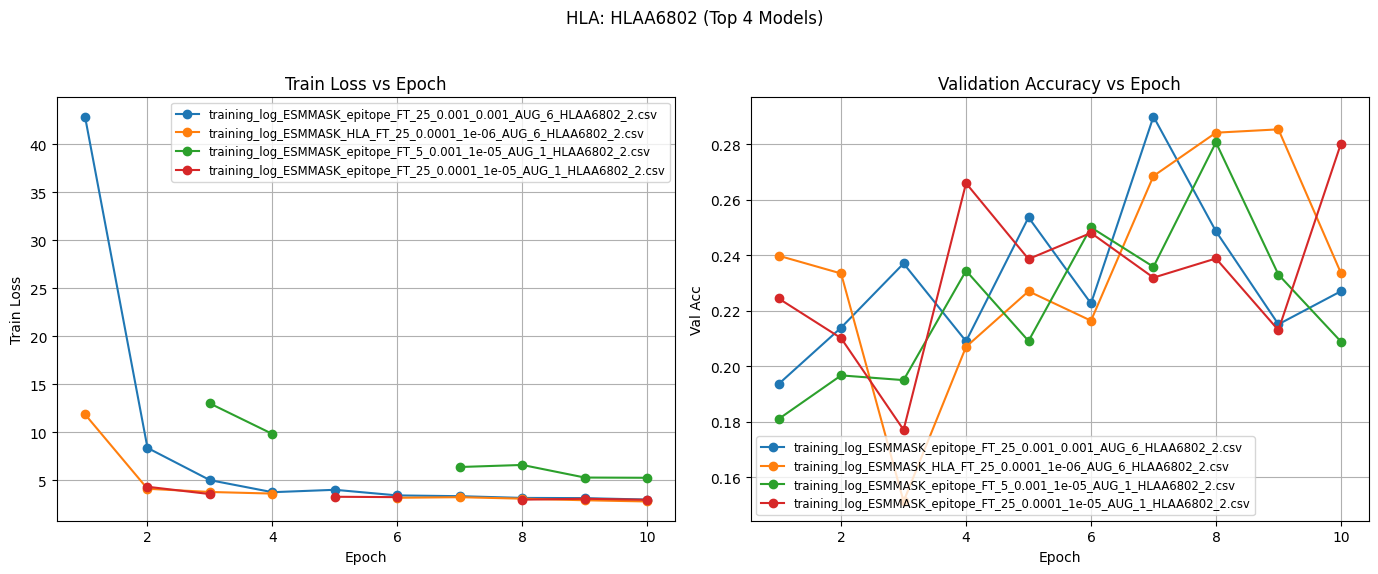

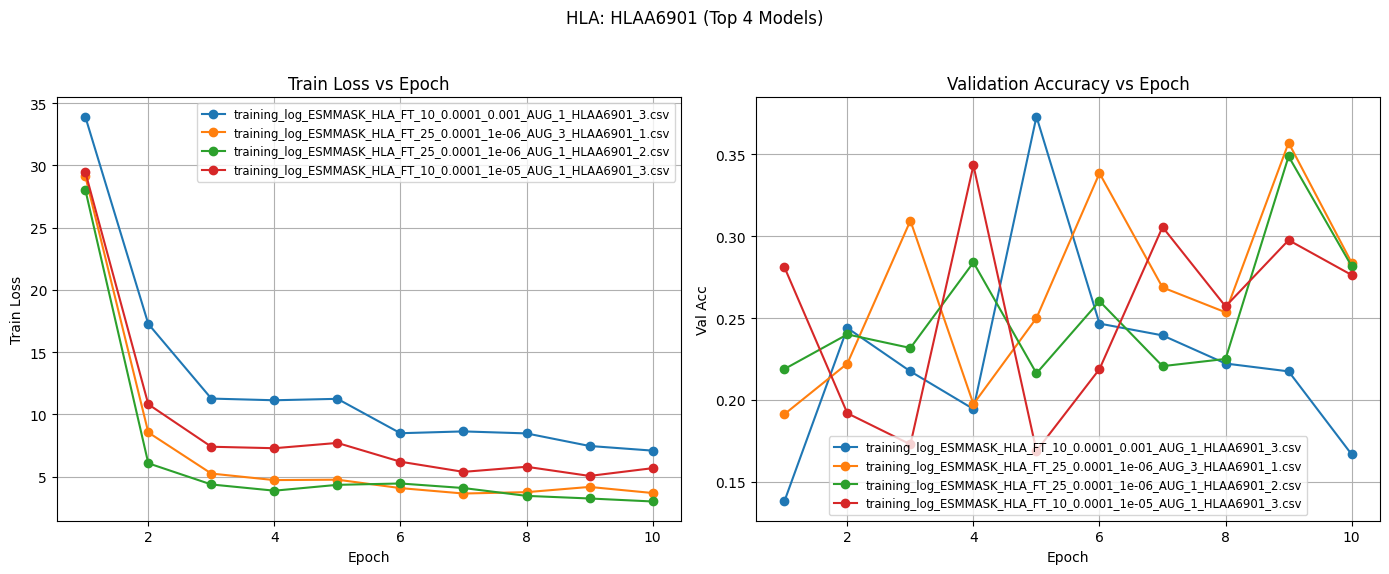

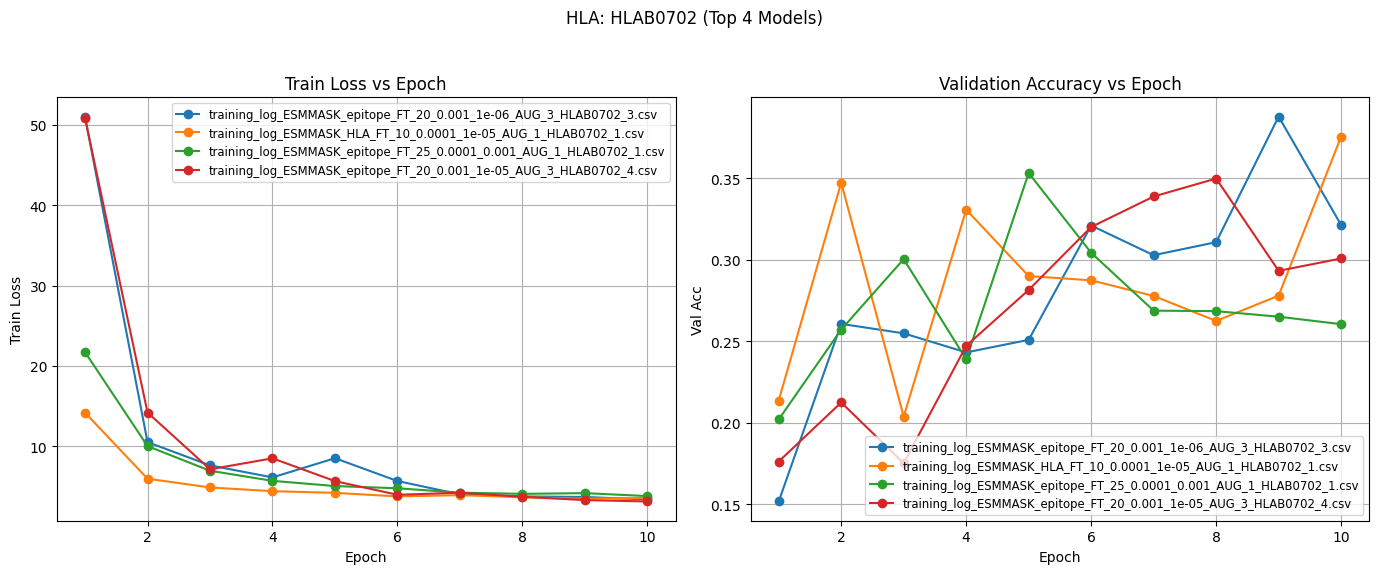

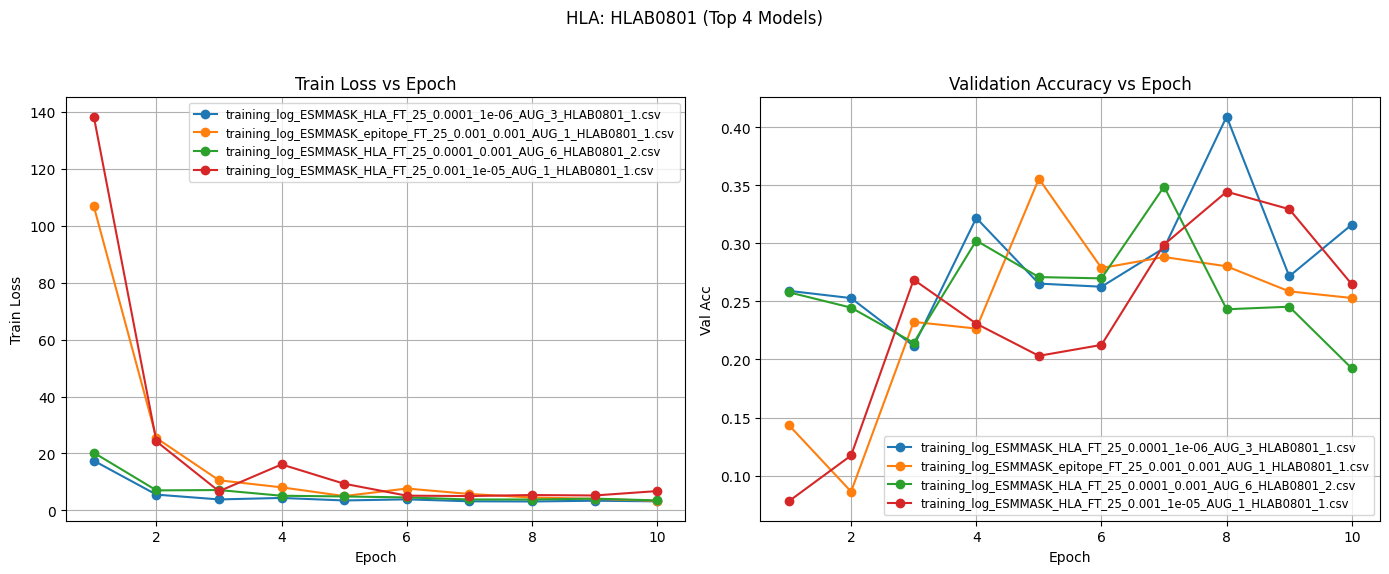

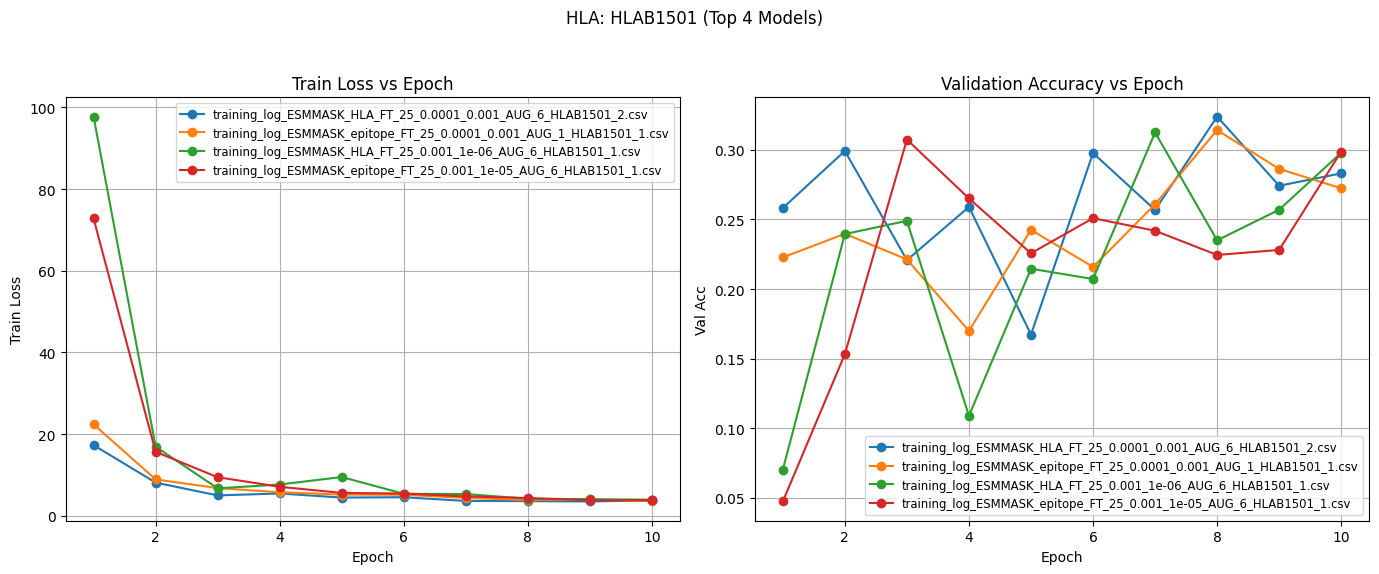

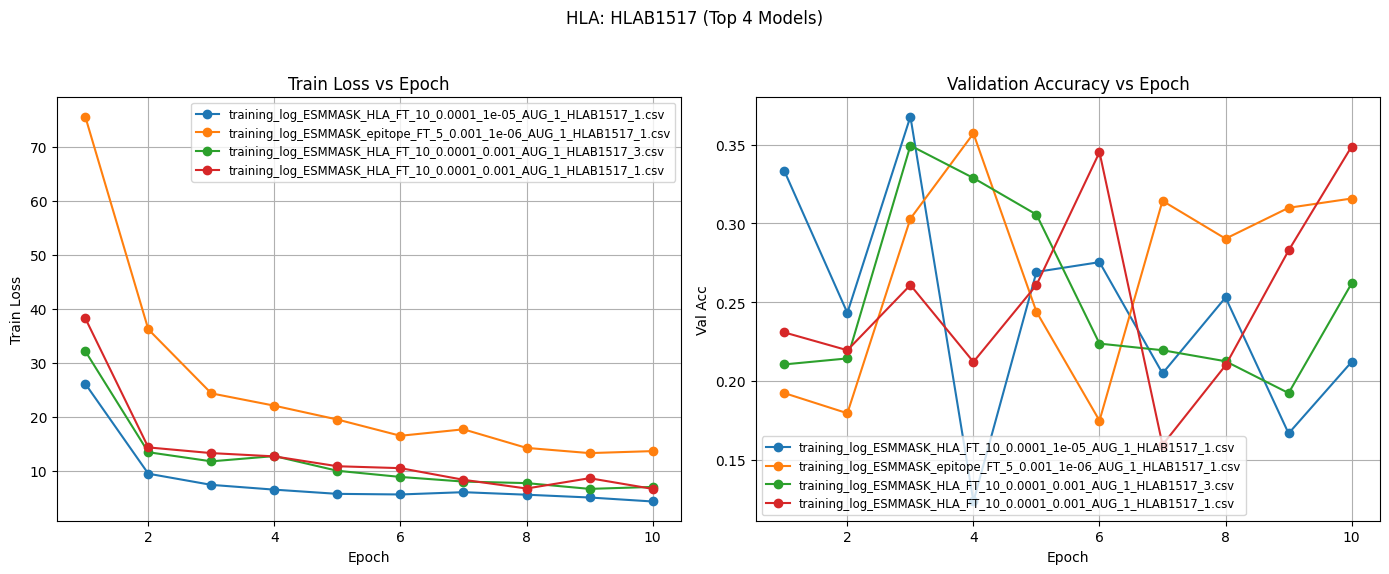

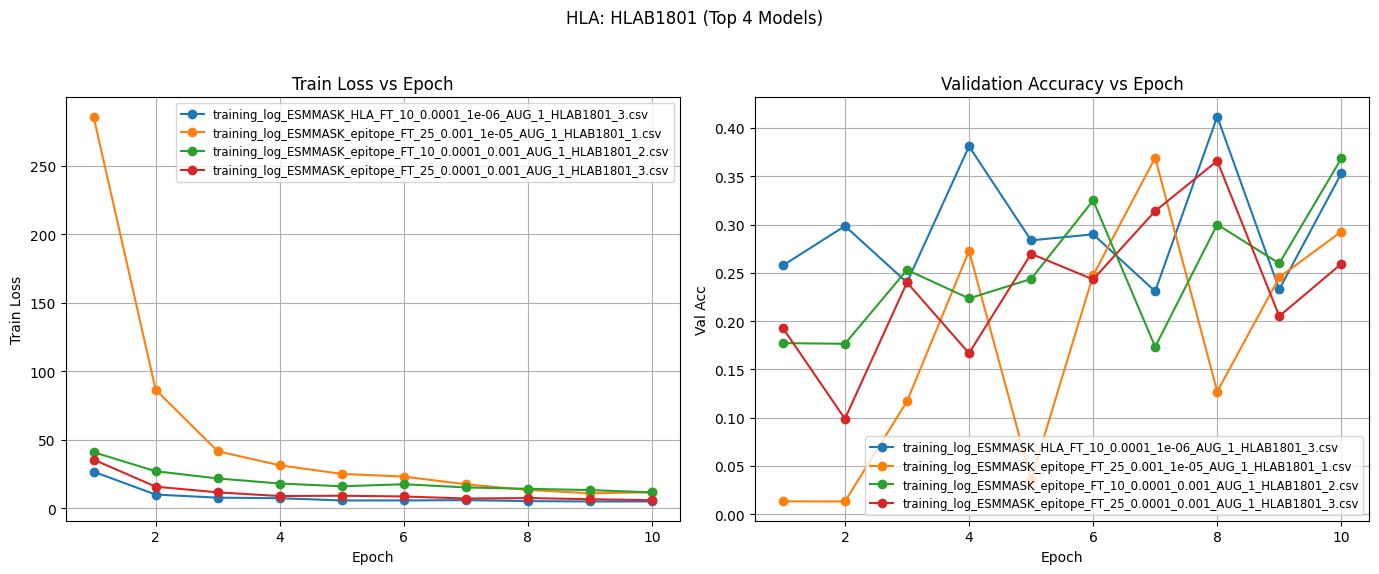

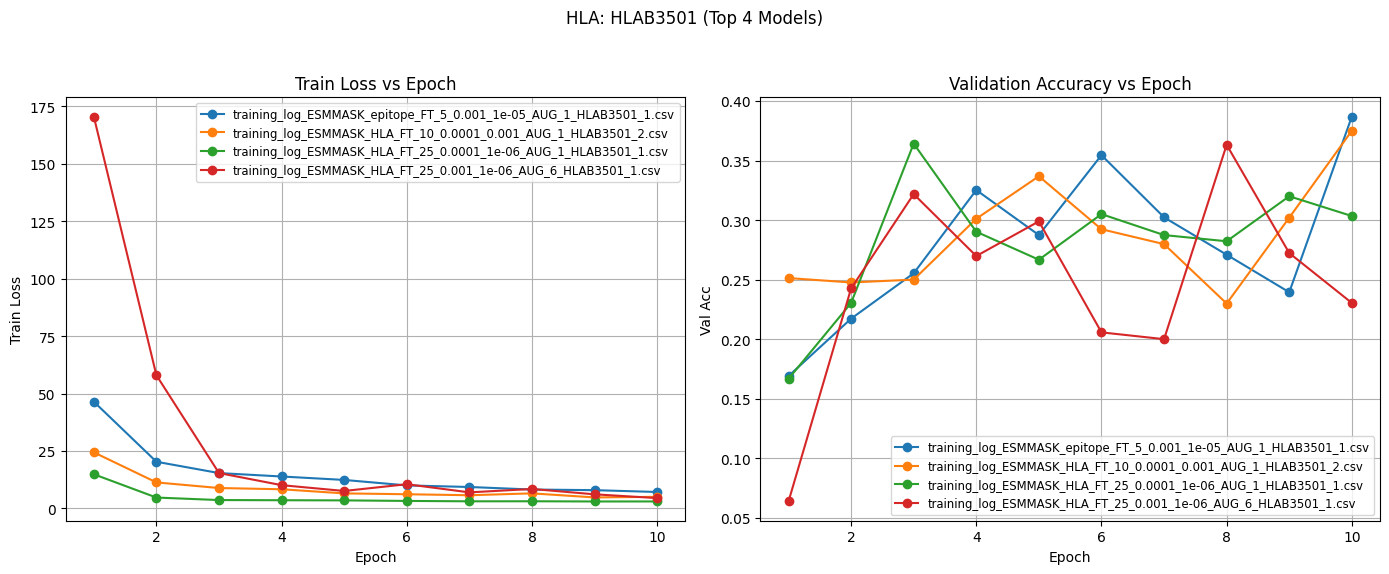

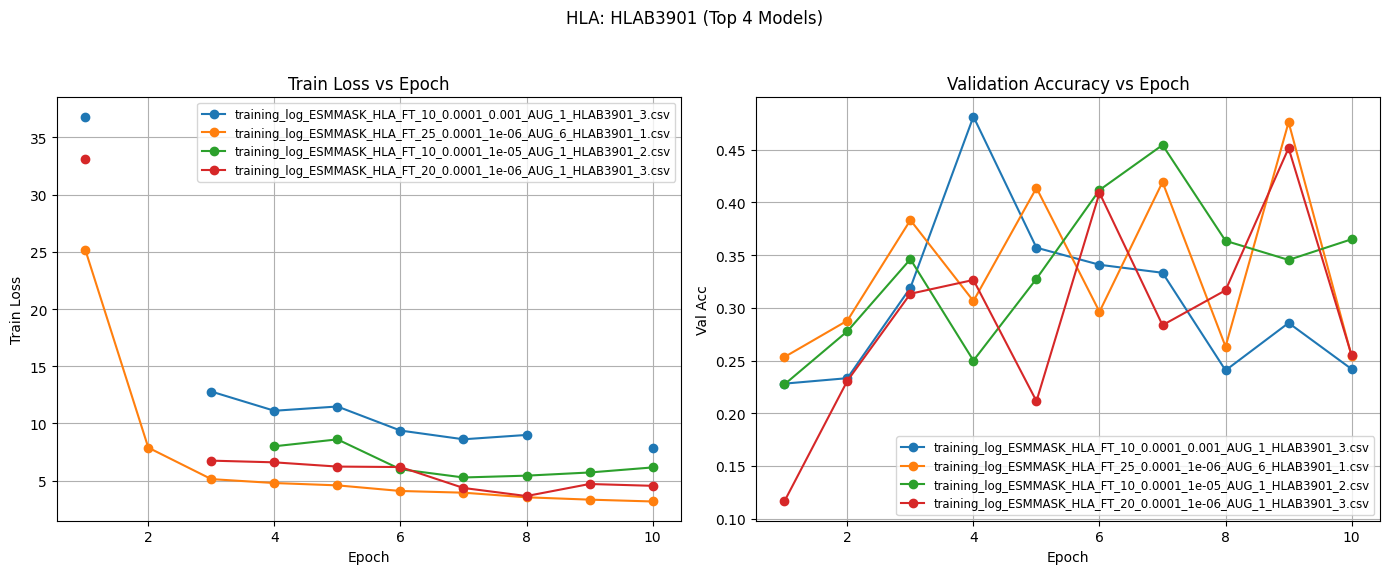

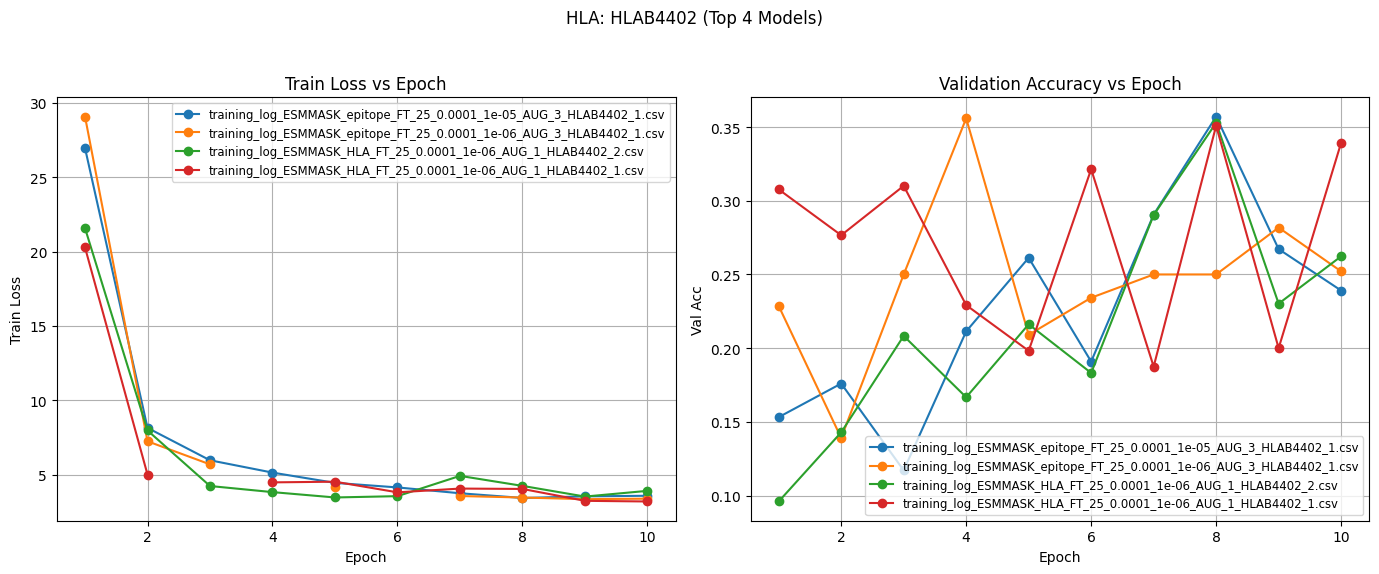

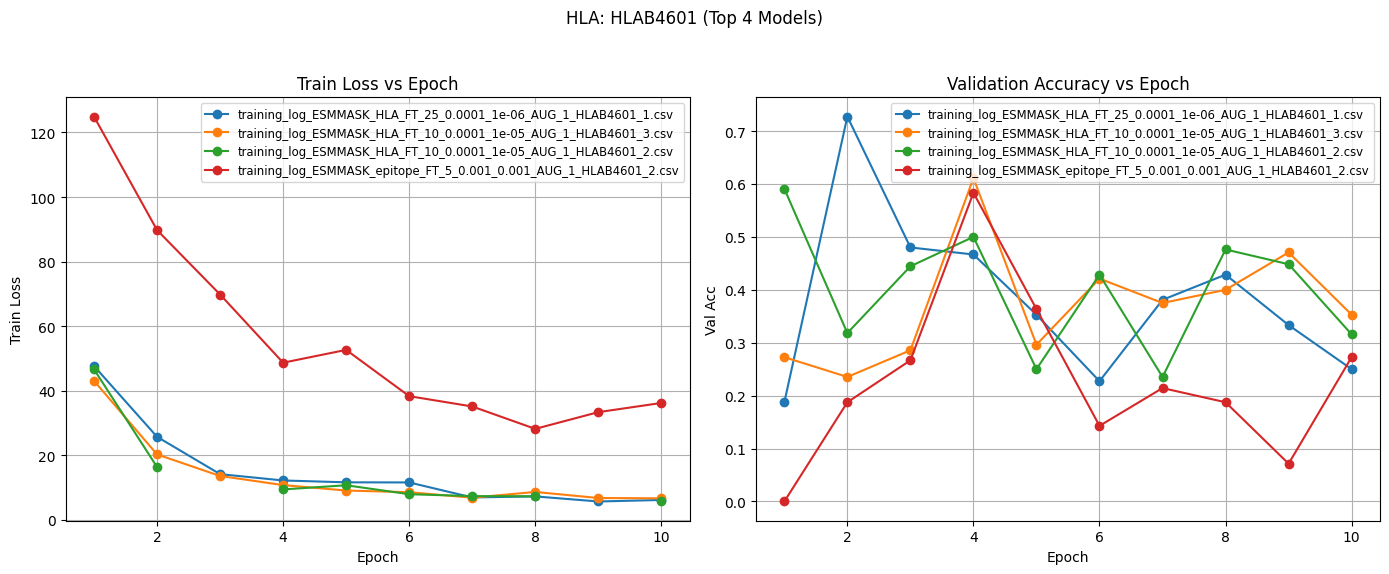

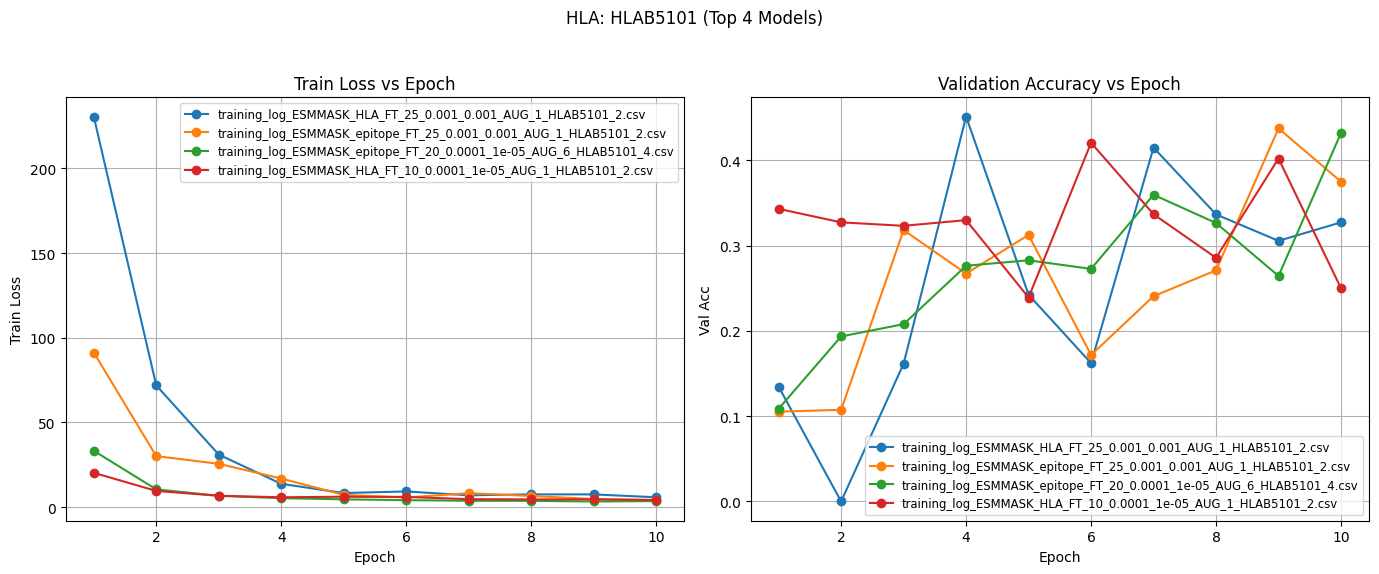

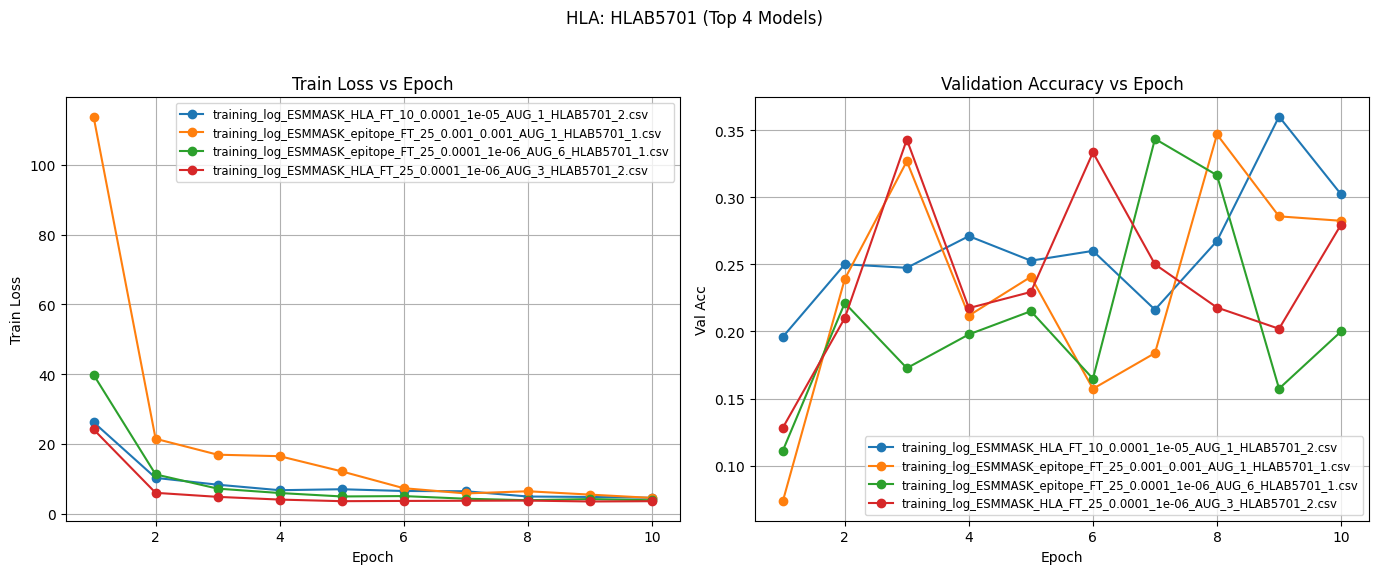

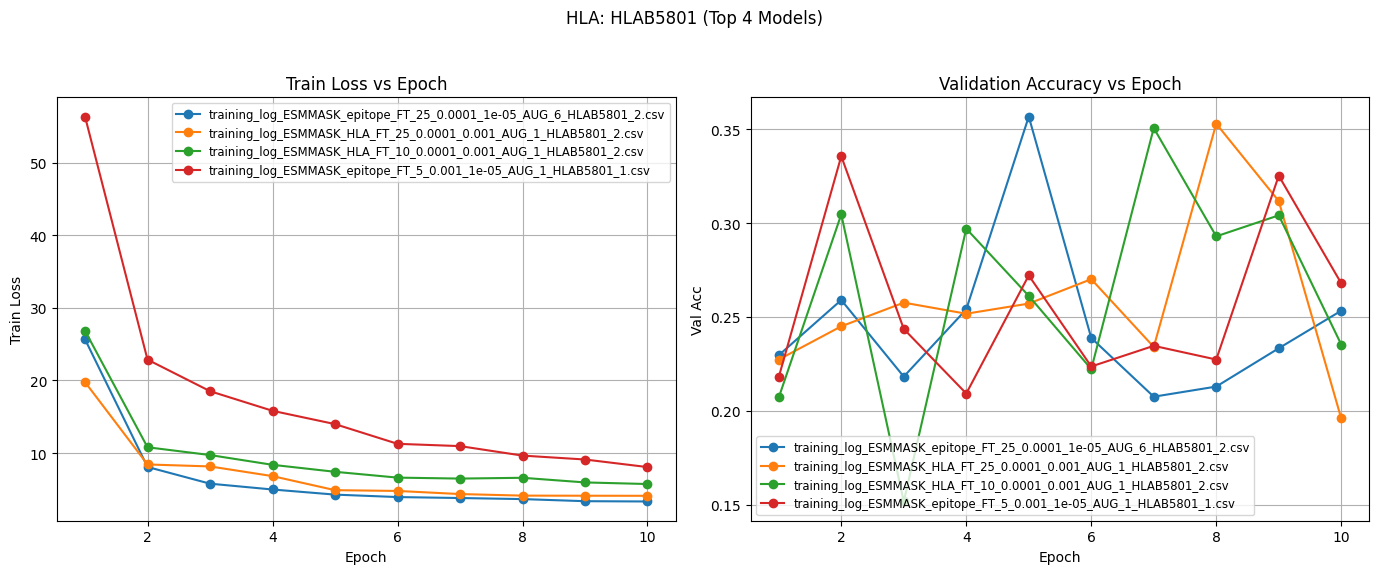

In [7]:
for hla, group in grouped:
    group_sorted = group.sort_values(by='max_val_acc', ascending=False).head(4)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'HLA: {hla} (Top {len(group_sorted)} Models)')
    
    for _, row in group_sorted.iterrows():
        df = pd.read_csv(row['file'])
        label = row['filename']
        if 'Epoch' in df.columns and 'Train Loss' in df.columns:
            ax1.plot(df['Epoch'], df['Train Loss'], marker='o', label=label)
        if 'Epoch' in df.columns and 'Val Acc' in df.columns:
            ax2.plot(df['Epoch'], df['Val Acc'], marker='o', label=label)
    
    ax1.set_title('Train Loss vs Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Train Loss')
    ax1.legend(fontsize='small', loc='best'); ax1.grid(True)
    ax2.set_title('Validation Accuracy vs Epoch'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Val Acc')
    ax2.legend(fontsize='small', loc='best'); ax2.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [8]:
sorted_acuraccies = []
for file_name in glob.glob('/global/scratch/users/sergiomar10/models/ESMC_Pretrain/*/*.pt'):
    try:
        file_name = file_name.split('/')[-1].replace('.pt', '.csv')
        file_name = f'/global/scratch/users/sergiomar10/data/ESMC_Pretrain/{file_name}'
        eval_df = pd.read_csv(file_name)
        eval_df = eval_df[eval_df['original_aa'] != '<eos>']
        eval_df['correct'] = eval_df['original_aa'] == eval_df['predicted_aa']
        size_of_eval_set = len(eval_df)
        creation_time = os.path.getctime(file_name)
        creation_date = datetime.datetime.fromtimestamp(creation_time)
        acuraccy = len(eval_df[eval_df['correct'] == 1]) / len(eval_df)
        sorted_acuraccies.append([file_name, creation_date, size_of_eval_set, acuraccy])
    except:
        print(file_name)

eval_acc = pd.DataFrame(sorted_acuraccies, columns=['file', 'date', 'eval_set_size', 'accuracy'])
eval_acc = eval_acc[eval_acc['accuracy'] < 0.8]

/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0101_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_0.001_AUG_1_HLAA0101_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_1e-06_AUG_6_HLAA0301_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_1e-06_AUG_6_HLAA0202_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretr

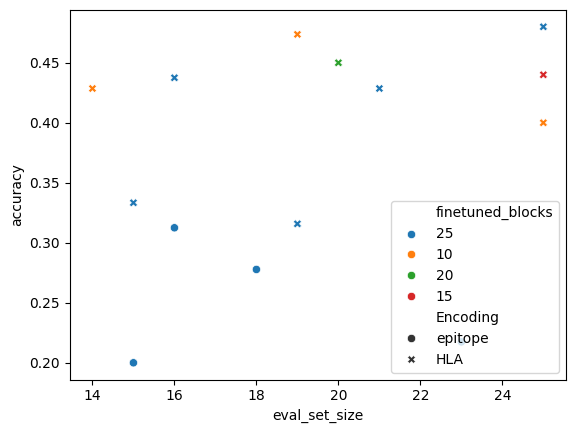

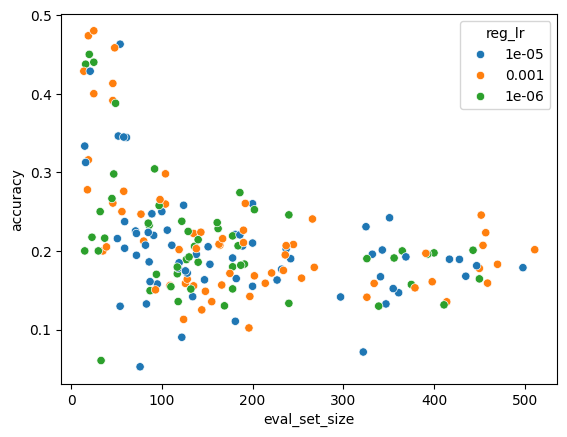

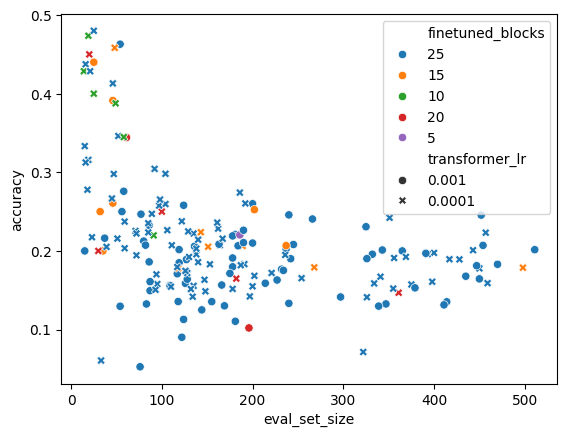

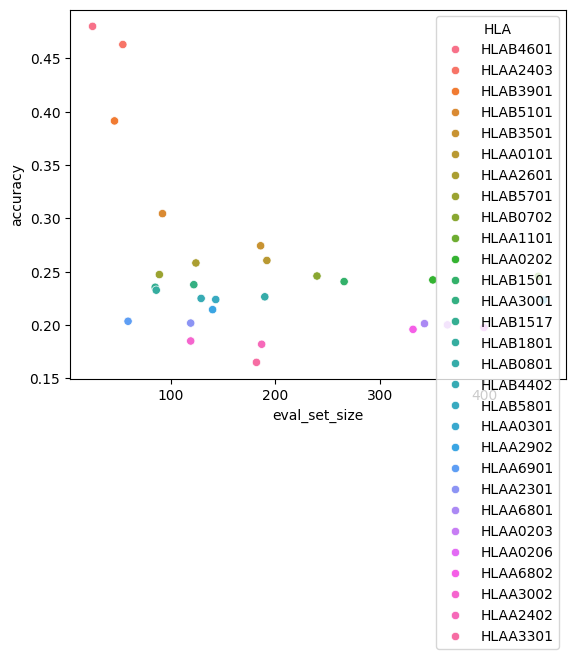

In [9]:
eval_acc['file'] = eval_acc['file'].str.split('/', expand=True)[7]
eval_acc['finetuned_blocks'] = eval_acc['file'].str.split('_', expand=True)[3]
eval_acc['transformer_lr'] = eval_acc['file'].str.split('_', expand=True)[4]
eval_acc['reg_lr'] = eval_acc['file'].str.split('_', expand=True)[5]
eval_acc['AUG'] = eval_acc['file'].str.split('_', expand=True)[7].astype('int')
eval_acc['HLA'] = eval_acc['file'].str.split('_', expand=True)[8]
eval_acc['Encoding'] = eval_acc['file'].str.split('_', expand=True)[1]

eval_acc.sort_values(by='accuracy', ascending=False).drop_duplicates(subset=['HLA', 'Encoding']).to_csv('ESMCBA_models.csv', index=None)

sns.scatterplot(data=eval_acc[eval_acc['HLA'] == 'HLAB4601'], x='eval_set_size', y='accuracy', hue='finetuned_blocks', style='Encoding')
plt.show()
sns.scatterplot(data=eval_acc, x='eval_set_size', y='accuracy', hue='reg_lr')
plt.show()
sns.scatterplot(data=eval_acc, x='eval_set_size', y='accuracy', hue='finetuned_blocks', style='transformer_lr')
plt.show()
evals_hla = eval_acc.sort_values(by='accuracy', ascending=False).drop_duplicates('HLA').head(30)
sns.scatterplot(data=evals_hla, x='eval_set_size', y='accuracy', hue='HLA')
plt.show()

In [25]:
eval_df = pd.read_csv('/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_25_0.001_1e-06_AUG_6_HLAA0301_2.csv')

In [26]:

eval_df = eval_df[eval_df['original_aa'] != '<eos>']
eval_df['correct'] = eval_df['original_aa'] == eval_df['predicted_aa']
eval_df['file'] = file_name
acuraccy = len(eval_df[eval_df['correct'] == 1]) /  len(eval_df)

In [27]:
acuraccy

0.21333333333333335

### Create SLURM files

In [40]:
################################################
# 6. Define a simple FASTA parser
################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        # Append the last sequence if present
        if seq:
            sequences.append((header, seq))
    return sequences


############################################
# 7. Load and filter the data
############################################
train_fasta = "/global/scratch/users/sergiomar10/jupyter_notebooks/hla_protein_sequences.fasta"
all_data = parse_fasta(train_fasta)

filtered_data = []
for header, sequence in all_data:
    if sequence[0] != 'M':
        continue
    if len(sequence) < 50:
        continue
    if 'X' in sequence:
        continue

    header = header.split('|')[1][:7].replace('*','').replace(':','')

    filtered_data.append(('HLA' + header))
    

In [47]:
[x for x in filtered_data if x not in eval_acc['HLA'].unique()]

['HLAA0201']

In [9]:
import itertools
import os
import glob

script_path = '/global/scratch/users/sergiomar10/py_files/ESM-C_ALLHLAs.py'
sh_file_dir = '/global/scratch/users/sergiomar10/slurm_jobs/ESMC_Pretrain2'
os.makedirs(sh_file_dir, exist_ok=True)

trials = [3, 4, 5]
encoding = ['epitope', 'HLA']
blocks_unfrozen = [15, 20, 25]
last_block_lr = [1e-3, 1e-4]
regression_block_lr = [1e-3, 1e-5, 1e-6]
HLAs = filtered_data
num_augmentations = [1, 3, 6]
                    
for trial_n, encode, num_block, lr_base, lr_reg, HLA, augs  in itertools.product(trials, encoding, blocks_unfrozen, last_block_lr, regression_block_lr, HLAs, num_augmentations):
    
    file_name = f'ESMMASK_{encode}_FT_{num_block}_{lr_base}_{lr_reg}_AUG_{augs}_{HLA}_{trial_n}'

    sh_filename = f'{file_name}.sh'
    sh_filepath = os.path.join(sh_file_dir, sh_filename)
    
    # Construct the command to run the script with the current parameters
    cmd = f'python3 {script_path} --name_of_model {file_name} --encoding {encode} --blocks_unfrozen {num_block} --base_block_lr {lr_base} --regression_block_lr {lr_reg} --HLA {HLA} --num_augmentations {augs}'

    with open(sh_filepath, 'w') as sh_file:
        sh_file.write('#!/bin/bash\n')
        sh_file.write('#SBATCH --account=co_nilah\n')
        sh_file.write('#SBATCH --partition=savio2_1080ti\n')
        sh_file.write('#SBATCH --qos=savio_lowprio\n')
        sh_file.write('#SBATCH --cpus-per-task=4\n')
        sh_file.write('#SBATCH --gres=gpu:1\n')
        sh_file.write('#SBATCH --requeue\n')
        sh_file.write('#SBATCH --time=00:20:00\n')
        sh_file.write(f'#SBATCH --job-name={file_name}\n')
        sh_file.write(f'#SBATCH --output=/global/scratch/users/sergiomar10/logs/ESMC_Pretrain/{file_name}_%j.out\n')
        sh_file.write(f'#SBATCH --error=/global/scratch/users/sergiomar10/logs/ESMC_Pretrain/{file_name}_%j.err\n')
        sh_file.write('source /clusterfs/nilah/sergio/miniconda3/etc/profile.d/conda.sh\n')
        sh_file.write('\n')
        sh_file.write('conda activate ESM_cambrian\n')
        sh_file.write('\n')

        sh_file.write(cmd + '\n')
        
    # Make the shell script executable
    os.chmod(sh_filepath, 0o755)
    
    print(f'Created shell script: {file_name}')




Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0206_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0